In [126]:
import gym
gym.__version__
# 0.23.0

'0.26.2'

In [127]:
# Imports
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

In [128]:
class PrioritizedReplayBuffer:
    def __init__(self, buffer_size, alpha=0.6, beta=0.4):
        self.alpha = alpha
        self.beta = beta
        self.buffer_size = buffer_size
        self.buffer = []
        self.position = 0
        self.priorities = np.zeros((buffer_size,), dtype=np.float32)

    def add(self, state, action, reward, state_, done):
        max_prio = self.priorities.max() if self.buffer else 1.0

        if len(self.buffer) < self.buffer_size:
            self.buffer.append((state, action, reward, state_, done))
        else:
            self.buffer[self.position] = (state, action, reward, state_, done)
        
        self.priorities[self.position] = max_prio
        self.position = (self.position + 1) % self.buffer_size

    def sample(self, batch_size):
        
        if len(self.buffer) == self.buffer_size:
            prios = self.priorities
        else:
            prios = self.priorities[:self.position]
        
        probs = prios ** self.alpha
        probs /= probs.sum()
        
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        
        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-self.beta)
        weights /= weights.max()
        weights = np.array(weights, dtype=np.float32)
        
        batch = list(zip(*samples))
        states = torch.tensor(np.array(batch[0]), dtype=torch.float32)
        actions = torch.tensor(np.array(batch[1]), dtype=torch.int64)
        rewards = torch.tensor(np.array(batch[2]), dtype=torch.float32)
        states_ = torch.tensor(np.array(batch[3]), dtype=torch.float32)
        dones = torch.tensor(np.array(batch[4]), dtype=torch.int64)
        return states, actions, rewards, states_, dones, indices, weights

    def update_priorities(self, batch_indices, batch_priorities):
        for idx, prio in zip(batch_indices, batch_priorities):
            self.priorities[idx] = prio
    def betas_increment(self,betas):
        self.betas=betas
    def __len__(self):
        return len(self.buffer)


In [129]:
# Neural Network and Agent Classes

# Define a neural network class that inherits from the PyTorch nn.Module class.
class LinearDeepQNetwork(nn.Module):
    def __init__(self, lr, n_actions, input_dims,arc):
        super(LinearDeepQNetwork, self).__init__()
        self.arc=arc
        if arc=="Double" or arc=="Single":
            # Define the neural network layers and activation functions.
            self.fc1 = nn.Linear(input_dims[0], 8)
            self.fc2 = nn.Linear(8, 16)
            self.fc3 = nn.Linear(16, 8)
            self.fc4 = nn.Linear(8, n_actions)
        elif arc=="Dueling" or arc=="Double Dueling":
            self.fc1 = nn.Linear(input_dims[0], 8)
            self.fc2 = nn.Linear(8, 16)
            self.fc3 = nn.Linear(16, 8)
            self.fc4 = nn.Linear(8, n_actions)

            self.Values1 = nn.Linear(n_actions, 8)
            self.Values2 = nn.Linear(8, 16)
            self.Values3 = nn.Linear(16, 1)

            self.advantage1 = nn.Linear(n_actions, 8)
            self.advantage2 = nn.Linear(8, 16)
            self.advantage3 = nn.Linear(16, n_actions)


        # Define the optimizer and loss function for training the neural network.
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.HuberLoss()
        self.device = torch.device('cpu')
        self.to(self.device)

    # Define the forward pass of the neural network.
    def forward(self, state):
        if self.arc=="Dueling" or self.arc=="Double Dueling":
            z = torch.relu(self.fc1(state))
            z = torch.relu(self.fc2(z))
            z = torch.relu(self.fc3(z))
            z = self.fc4(z)

            values=torch.relu(self.Values1(z))
            values=torch.relu(self.Values2(values))
            values=(self.Values3(values))

            advantage=torch.relu(self.advantage1(z))
            advantage=torch.relu(self.advantage2(advantage))
            advantage=(self.advantage3(advantage))

            advantage_means=torch.mean(advantage)
            qvals = values + (advantage - advantage_means.view(-1,1))

            return qvals
        elif self.arc=="Double" or self.arc=="Single":
            layer1 = torch.relu(self.fc1(state))
            layer2 = torch.relu(self.fc2(layer1))
            layer3 = torch.relu(self.fc3(layer2))
            qvals = self.fc4(layer3)

            return qvals


# Define an agent class for training the neural network.
class Agent():
    def __init__(self, input_dims, n_actions,arc, buffer_size=2500, lr=5e-4, gamma=0.99,
                epsilon=1.0, eps_min=0.01):
        self.betas=0.4
        self.lr = lr
        self.input_dims = input_dims
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_min
        self.action_space = [i for i in range(self.n_actions)]
        self.arc=arc
        self.buffer_size=buffer_size

        # Create instances of the neural networks for the agent.
        if self.arc=="Single" or self.arc=="Dueling":
            self.Q_network = LinearDeepQNetwork(self.lr, self.n_actions, self.input_dims,self.arc)
        else:
            self.Q_network = LinearDeepQNetwork(self.lr, self.n_actions, self.input_dims,self.arc)
            self.Target_network = LinearDeepQNetwork(self.lr, self.n_actions, self.input_dims,self.arc)
            # Create Priority Replay Buffer
        self.priority_replay_buffer = PrioritizedReplayBuffer(buffer_size,self.betas)

    # Update the target network initially to match the online network.
    def update_target_network(self):
        if self.arc=="Single" or self.arc=="Dueling":
            pass
        else:
            self.Target_network.load_state_dict(self.Q_network.state_dict())

    # Define a function for choosing an action given an observation.
    def choose_action(self, state):
        if np.random.random() > self.epsilon:
            # Use the neural network to predict the Q-values for the current state.
            state = torch.tensor(state, dtype=torch.float).to(self.Q_network.device)
            actions = self.Q_network.forward(state)
            # Choose the action with the highest Q-value.
            action = torch.argmax(actions).item()
        else:
            # Choose a random action with probability epsilon.
            action = np.random.choice(self.action_space)

        return action

    # Define a function for decrementing epsilon over time to decrease exploration.
    def decrement_epsilon(self,decrement):
        self.epsilon = self.epsilon - decrement if self.epsilon > self.eps_min else self.eps_min

    # Define a function for training the neural network with a batch of experiences.
    def learn(self, states, actions, rewards, states_, dones,indices, weights):
        self.Q_network.optimizer.zero_grad()

        # Convert the data to PyTorch tensors and move to the device for training.
        states = states.to(self.Q_network.device)
        actions = actions.to(self.Q_network.device)
        rewards = rewards.to(self.Q_network.device)
        weights = torch.tensor(weights).to(self.Q_network.device)
        if self.arc=="Dueling" or self.arc=="Single":
            states_ = states_.to(self.Q_network.device)
            dones = dones.to(self.Q_network.device)

            # Use the online network to predict the Q-values for the current states and select actions.
            q_pred = self.Q_network.forward(states).gather(1, actions.reshape(-1, 1))

            # Use the target network to predict the Q-values for the next states.
            q_next, _ = torch.max(self.Q_network.forward(states_), dim=1)
            
        else:
            states_ = states_.to(self.Target_network.device)
            dones = dones.to(self.Target_network.device)

            # Use the online network to predict the Q-values for the current states and select actions.
            q_pred = self.Q_network.forward(states).gather(1, actions.reshape(-1, 1))
            
            # Use the target network to predict the Q-values for the next states.
            q_next, _ = torch.max(self.Target_network.forward(states_), dim=1)

        # Calculate the target Q-values based on the current rewards and expected future rewards.
        q_target = rewards + self.gamma * (1-dones) * q_next
        q_target = q_target.detach()

        # Calculate the mean squared error loss between the predicted and target Q-values.
        loss  = (q_pred.squeeze() - q_target).pow(2) * weights
        prios = loss + 0.01
        loss  = loss.mean()
        loss.backward()
        self.Q_network.optimizer.step()
        self.priority_replay_buffer.update_priorities(indices, prios.data.cpu().numpy())
        
    def save(self, path):
        torch.save(self.Q_network.state_dict(), path)

    def load(self, path):
        self.Q_network.load_state_dict(torch.load(path))
    def update_beta(self,betas):
            self.priority_replay_buffer.betas_increment(betas)

In [130]:
def train_agent(agent, env, env_name, episodes, decrement, save_path, target_update_freq, batch_size,truncated):
    # Lists to store scores, epsilons, and x-axis values
    x_axis, scores, epsilons = [], [], []
    betas=0.4
    for i in range(episodes):
        score = 0
        done = False
        state = env.reset()[0]
        steps = 0
        betas += 0.6 / (episodes) 
        if betas >=1:
            betas=1

        while not done:
            # Choose an action based on the current state
            action = agent.choose_action(state)
            agent.update_beta(betas)
            # Take a step in the environment
            state_, reward, done,_, info = env.step(action)
            agent.priority_replay_buffer.add(state, action, reward, state_, done)  # Add the experience to the replay buffer

            if len(agent.priority_replay_buffer) > batch_size:
                states, actions, rewards, states_, dones, indices, weights = agent.priority_replay_buffer.sample(batch_size)  # Sample a batch of experiences
                agent.learn(states, actions, rewards, states_, dones, indices, weights)  # Train the agent with the sampled exper

            state = state_
            score += reward
            steps += 1

            # Terminate episode early for CartPole and Acrobot environments
            if env_name == 'CartPole-v1':
                if steps > 2000:
                    break
            elif env_name == 'Acrobot-v1':
                if steps > 300:
                    break
            elif env_name =="LunarLander-v2":
                if steps > 1000:
                    break
            if steps > truncated:
                print(truncated)
                print(steps)
                break
        # Decrement epsilon for exploration-exploitation trade-off
        agent.decrement_epsilon(decrement)

        # Update the target network periodically
        if i % target_update_freq == 0:
            agent.update_target_network()

        # Store scores and epsilons at specified intervals
        x_axis.append(i + 1)
        scores.append(score)
        epsilons.append(agent.epsilon)

        # Print episode information
        if (i + 1) % (save_score_freq + 4) == 0:
            avg_score = np.mean(scores[-save_score_freq+4:]) if len(scores) > 0 else 0.0
            print(f'Episode {i + 1}, last score {score:.1f}, avg score {avg_score:.1f}, epsilon {agent.epsilon:.2f}')

    # Save the trained agent
    agent.save(save_path)

    return x_axis, scores, epsilons


In [131]:
def print_environment_information(env_name,state_dim,action_dim,arc):
        print(f'------------------------')
        print(f'Current environment: {env_name}')
        print(f'state dim {state_dim}')
        print(f'action dim {action_dim}')
        print(f'------------------------')
        print(f'Current architecture: {arc}')
        print(f'------------------------')

In [ ]:
def plot_results(all_scores,save_path,x_axis,epsilons,episodes,arc):
    fig, ax = plt.subplots()
        # Calculate and plot the average score curve
    mean_scores = np.mean(all_scores, axis=0)
    np.savetxt(f'{save_path}_mean', mean_scores, delimiter=",")
    ax.plot(x_axis, mean_scores, 'k-', label='Average Score')
    ax.set_xlabel('x')
    ax.set_ylabel('score', color='b')

    # Plot the epsilon curve on the same plot using a second y-axis.
    ax2 = ax.twinx()
    ax2.plot(x_axis, epsilons, 'r-', label='epsilon')
    ax2.set_ylabel('epsilon', color='r')

    # Combine the legends from both y-axes.
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='lower left')

    # Set the title of the plot
    plot_title = f"Episodes: {episodes} - {arc} Q Network"
    plt.title(plot_title)

    # Save the plot and display it
    plt.savefig(save_path)
    plt.show()


In [132]:
# Define environment and truncation
environments = ['CartPole-v1','Acrobot-v1','LunarLander-v2']
n_episodes = [500]
truncation = {'CartPole-v1': 2000, 'Acrobot-v1': 300, 'LunarLander-v2': 800}

# Define testing Architectures and exploration percentage
architecture = ["Single","Double","Double Dueling","Dueling"]
validation_amount = 5
exploration_percentage = 0.70 

# Set other parameters for training
target_update_freq = 5
buffer_size = 500
batch_size = 64
learning_rate = 0.0005
gamma = 0.99


------------------------
Current environment: CartPole-v1
state dim (4,)
action dim 2
------------------------
Current architecture: Single
------------------------
Number of episodes in this run: 500
------------------------
Episode 5, last score 14.0, avg score 16.5, epsilon 0.99
Episode 10, last score 21.0, avg score 18.6, epsilon 0.97
Episode 15, last score 42.0, avg score 19.8, epsilon 0.96
Episode 20, last score 19.0, avg score 20.7, epsilon 0.94
Episode 25, last score 14.0, avg score 22.2, epsilon 0.93
Episode 30, last score 18.0, avg score 21.1, epsilon 0.92
Episode 35, last score 16.0, avg score 21.1, epsilon 0.90
Episode 40, last score 20.0, avg score 20.3, epsilon 0.89
Episode 45, last score 13.0, avg score 20.5, epsilon 0.87
Episode 50, last score 18.0, avg score 20.7, epsilon 0.86
Episode 55, last score 14.0, avg score 20.4, epsilon 0.84


KeyboardInterrupt: 

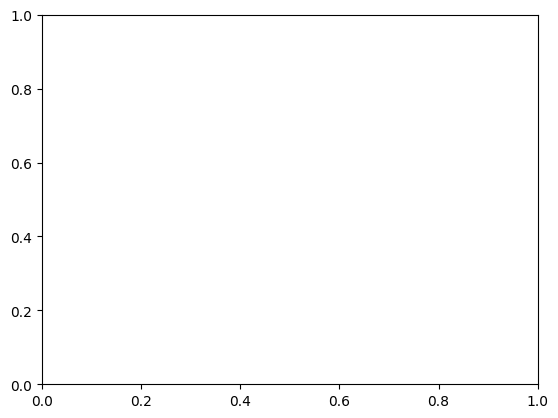

In [133]:
# Iterate over each environment
for env_name in environments:
    env = gym.make(env_name)

    # Get the dimension of the state and action spaces
    state_dim = env.reset()[0].shape
    action_dim = env.action_space.n

    # Create an array to store average scores for each architecture and validation run
    average_scores = np.zeros((len(architecture), validation_amount))
    truncated = truncation[env_name]

    # Iterate over each architecture
    for arc_idx, arc in enumerate(architecture):
        print_environment_information(env_name,state_dim,action_dim,arc)

        # Create a list to store scores for each validation run
        all_scores = [[] for _ in range(validation_amount)]
        
        # Iterate over the number of episodes
        for episodes in n_episodes:
            i=0
            # Run the specified number of validation runs
            for _ in range(validation_amount):
                print(f'Number of episodes in this run: {episodes}')
                print(f'------------------------')

                # Set exploration and decrement values
                decrement = 0.99 / (episodes * exploration_percentage)

                # Set save path for model
                save_path = f'models_priority{exploration_percentage}/{env_name}/{arc}/{env_name}_{episodes}_episodes'

                # Create a replay buffer and agent
                agent = Agent(input_dims=state_dim, n_actions=action_dim,arc=arc,buffer_size=buffer_size \
                              ,gamma=gamma,lr=learning_rate)

                # Train the agent and obtain scores and epsilons
                x_axis, scores, epsilons = train_agent(agent, env, env_name, episodes, decrement, save_path,\
                                                        target_update_freq, batch_size,truncated)

                # Store scores for this validation run
                all_scores[i] = scores
                i += 1
            
            # Calculate and plot the average score curve
            plot_results(all_scores,save_path,x_axis,epsilons,episodes,arc)

In [ ]:
def read_mean_scores(file_paths):
    mean_scores = []
    for file_path in file_paths:
        scores = np.loadtxt(file_path)
        mean_scores.append(scores)
    return mean_scores

def calculate_epsilon(episodes, exploration_percentage):
    epsilon = 1.0
    decrement = 0.99 / (episodes * exploration_percentage)
    epsilon_values = [epsilon]
    for _ in range(episodes - 1):
        epsilon -= decrement
        if epsilon < 0:
            epsilon = 0
        epsilon_values.append(epsilon)
    return epsilon_values

def moving_average(x, y, window_size, use_moving_average=True):
    if use_moving_average:
        weights = np.repeat(1.0, window_size) / window_size
        smoothed = np.convolve(y, weights, 'valid')
        x_smoothed = x[window_size // 2: -(window_size // 2) + 1]
        return x_smoothed, smoothed
    else:
        return x, y


def plot_numbers(episodes, env, architectures, num_episodes, epsilon_values, save_path):
    fig, ax = plt.subplots()
    x_axis = np.arange(1, num_episodes + 1)

    for i, arc in enumerate(architectures):
        numbers = episodes[i]
        x_smoothed, numbers_smoothed = moving_average(x_axis, numbers, 12)
        ax.plot(x_smoothed, numbers_smoothed, label=f"{arc}")

    ax.set_xlabel('x')
    ax.set_ylabel('score', color='b')
    ax.axhline(y=-100, color='black', linestyle='--')  # Add a black horizontal line at y=200

    ax2 = ax.twinx()
    ax2.plot(x_axis, epsilon_values, 'r-', label='epsilon')
    ax2.set_ylabel('epsilon', color='r')

    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    all_lines = lines1 + lines2
    all_labels = labels1 + labels2

    legend = ax.legend(all_lines, all_labels, loc='lower right')  # Change legend position to 'lower right'
    legend.set_bbox_to_anchor((0.335, -0.02))  # Adjust the legend position by changing the values (1, 0.9)
    legend.get_frame().set_linewidth(0.5)  # Reduce the legend frame thickness
    legend.fontsize='small'

    plot_title = f"{env} Episodes: {num_episodes}"
    ax.set_title(plot_title)

    plt.savefig(save_path)
    plt.show()




# Example usage:
base_data_path = "models_priority2/{env}/{arc}/{env}_{episodes}_episodes_mean"
base_plot_path = "models_priority2/{env}/{env}_{episodes}_plotted_mean"
episode_numbers = [100, 250,500]
environments = ['Acrobot-v1'] 
architectures = [["Single","Double","Double Dueling","Dueling"]]
exploration_percentage = 0.40

for env in environments:
    for num_episodes in episode_numbers:
        for arcs in architectures:
            data_paths = [base_data_path.format(env=env, arc=arc, episodes=num_episodes) for arc in arcs]
            mean_scores = read_mean_scores(data_paths)
            epsilon_values = calculate_epsilon(num_episodes, exploration_percentage)
            plot_path = base_plot_path.format(env=env, episodes=num_episodes)
            plot_numbers(mean_scores, env, arcs, num_episodes, epsilon_values, plot_path)


OSError: models_priority2/Acrobot-v1/Single/Acrobot-v1_100_episodes_mean not found.